In [64]:
%load_ext autoreload
%autoreload
import os
import torch 
d = torch.device('cuda:3')
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from RS.utils.dictutils import *
from sklearn.preprocessing import normalize
from RS.utils.dataset import Dataset as Mydataset
from RS.utils.evaluation import Evaluate
dataroot = os.path.join("data")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recommend

## METHOD1
Using all courses that a user have had taken.  



In [82]:
from RS.commoncourse import recommend_according_course_selection_records

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
commoncourse_savepath = os.path.join("result", "commoncourse")
if not os.path.exists(commoncourse_savepath):
    print(f"mkdir : {commoncourse_savepath}")
    os.mkdir(commoncourse_savepath)

### Steps:

1. __Generate__ $M_{category \times course}$

  - Input:
    - $M_{u_\text{train} \times category}$ : 
      - each entry $(u_j, cate_i)$ means the counts of category $cate_i$ being lended  by the trained-user $u_{j}$
    - $M_{u_{\text{train}} \times course}$ :
      - each entry $(u_j,course_k)$ means whether the trained-user $u_j$ had taken the course $course_k$. It is a binary matrix.

  - Output : 
    - $M_{category \times {course}}$: 
      - each entry of it means the mean counts of $category_i$ lended by the training students who had taken $course_j$.

  - Steps:
    1. $M_{norm, u_\text{train}\times course} := $ normalize $M_{u_\text{{train}} \times course}$ along it's column by $L_1$ norm.

    2. $M_{category \times {course}} \gets M_{u_\text{{train}} \times category}^T \times  M_{norm, u_\text{{train}}\times course}$

    3. return  $M_{category \times {course}}$

2. Generate recommend list: 

    $\textbf{for}$ each ${u_{\text{test}_\text{t}}}\in $ testing users:

  - Input (from step 1. directly):
    - $M_{ij}$: 
      - Mean counts of $\text{category}_i$ lended by the training students who had taken $\text{course}_j$. 

    - $Course_{u_{\text{test}_\text{t}}}$: 
      - $\{course_{i} \textbf{ }| \textbf{ } course_{i} \in$  course selection records of  ${u_{\text{test}_\text{t}}} \}$.
    - $topN$: 
      - top-N categories needed to be recommended.
  - Output : 
    - topN Recommend categories for a cold-started user ${u_{\text{test}_\text{t}}}$

  - Steps :
    1. __initialize__ : $CategoryCount_{{u_{\text{test}_\text{t}}}} := [0]_{1 \times |categories|}$

    2. For {$category_i$ $\in$ all categories}
      - $CategoryCount_{u_{\text{test}_\text{t}}}[category_i] \gets \frac{ \displaystyle\sum_{course_j\in Course_{u_{\text{test}_\text{t}}}} M[category_i][course_j]}{|Course_{u_{\text{test}_\text{t}}}|}$

    3. return category indices of $topN$ maximum values of $CategoryCount_{u_{\text{test}_\text{t}}}$

In [ ]:
datafolder = {
    "training_user_course":os.path.join(
        dataroot,"course","train.csv"
    ),
    "training_user_book":os.path.join(
        dataroot,"book","user_cate3_train.csv"
    ),
    "testing_user_course":os.path.join(
        dataroot, "course", "test.csv"
    )
}


dataset = Mydataset(datafolder=datafolder)

In [11]:
rslist_saving_path = recommend_according_course_selection_records(
    dataset=dataset, resultroot=commoncourse_savepath, d=d
)

build book x user .. OK ..
prediction ..


100%|██████████| 1254/1254 [00:00<00:00, 1419.83it/s]


OK .. save at result/commoncourse/recommendlist.json


### Evaluation

In [53]:
rslist_saving_path=os.path.join(
    commoncourse_savepath, "recommendlist.json"
)

Evaluate(
    result_root=commoncourse_savepath, 
    recommendlist = rslist_saving_path,
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=list(str(i) for i in range(1000))
)

result/commoncourse/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:45<00:00,  1.19s/it]


Precision_Recall_F1 : result/commoncourse/metrics/metrics.jpg
PR : result/commoncourse/metrics/PR.jpg
ROC : result/commoncourse/metrics/ROC.jpg


#### Zoom in top k

In [58]:
from RS.utils.plotutils import plot_PRF1_different_n 

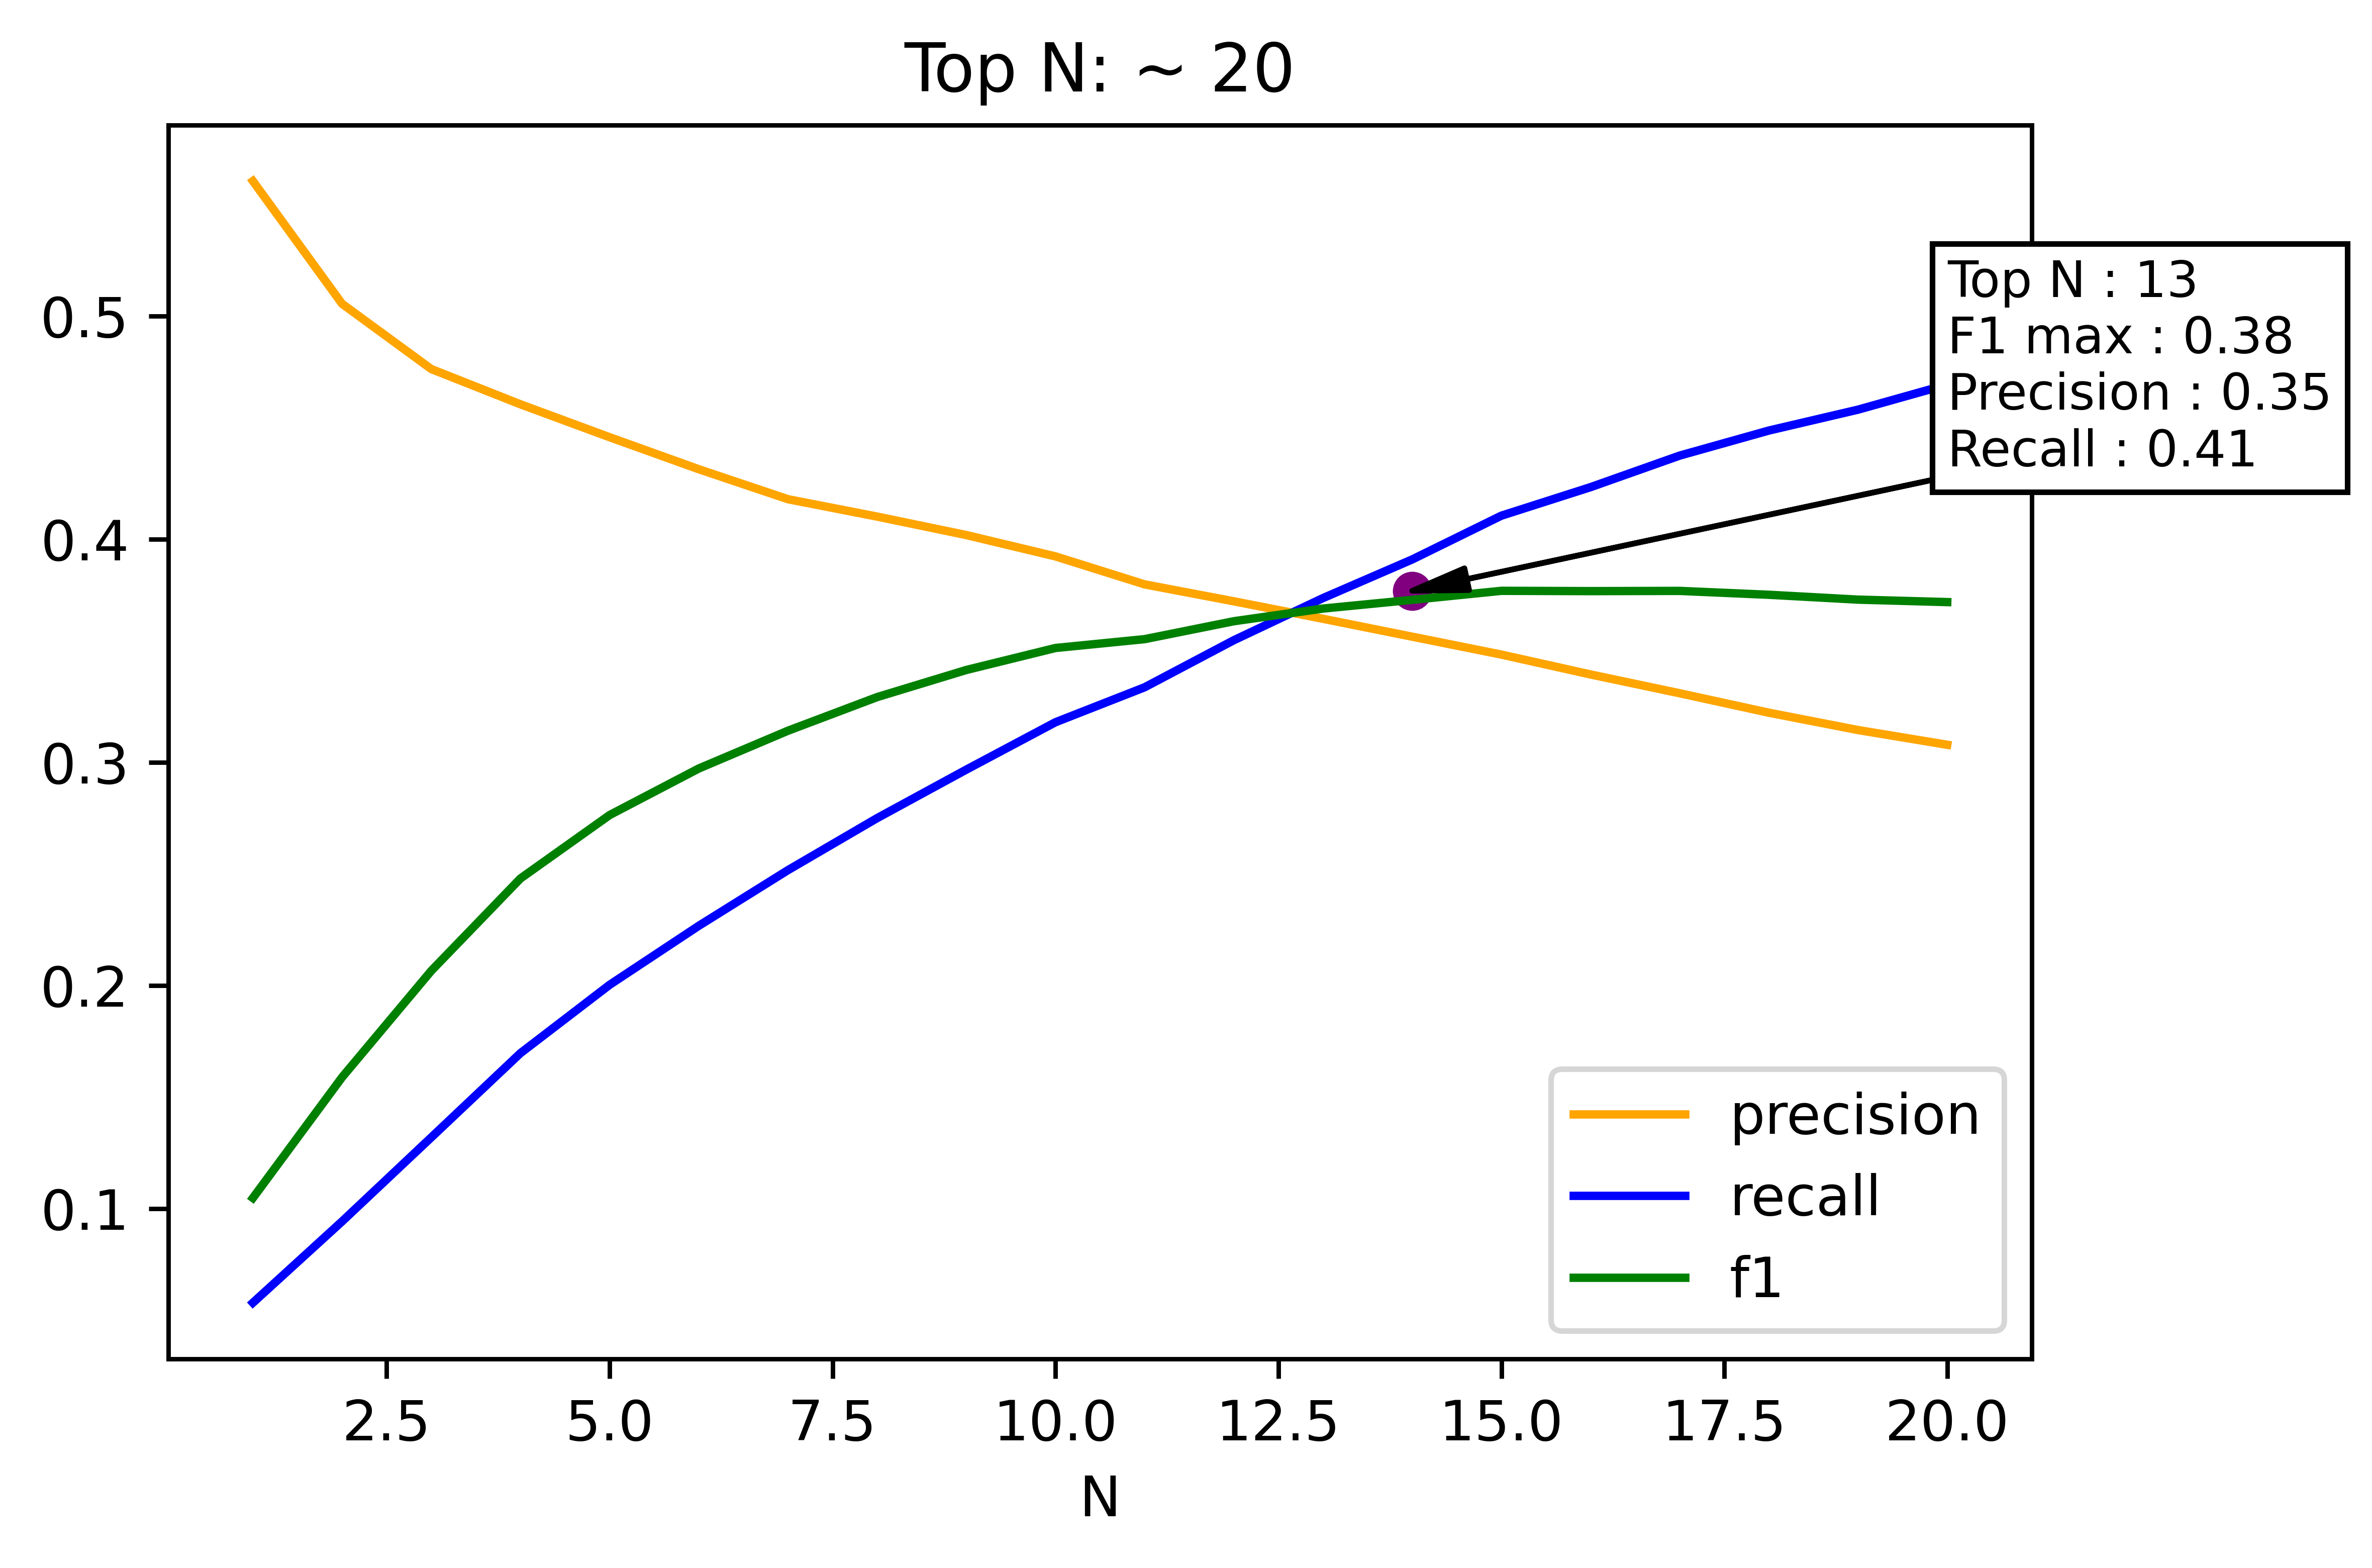

In [63]:
topk = 20
metrics = loadjson(
    os.path.join(commoncourse_savepath,"metrics","metrics.json")
)
plot_PRF1_different_n(
    prec=metrics['precision'][:topk],
    recall=metrics['recall'][:topk],
    f1=metrics['f1'][:topk],
    savepath=os.path.join(commoncourse_savepath, "metrics", "metrics_zoomin.jpg"),
    showinline=True
)

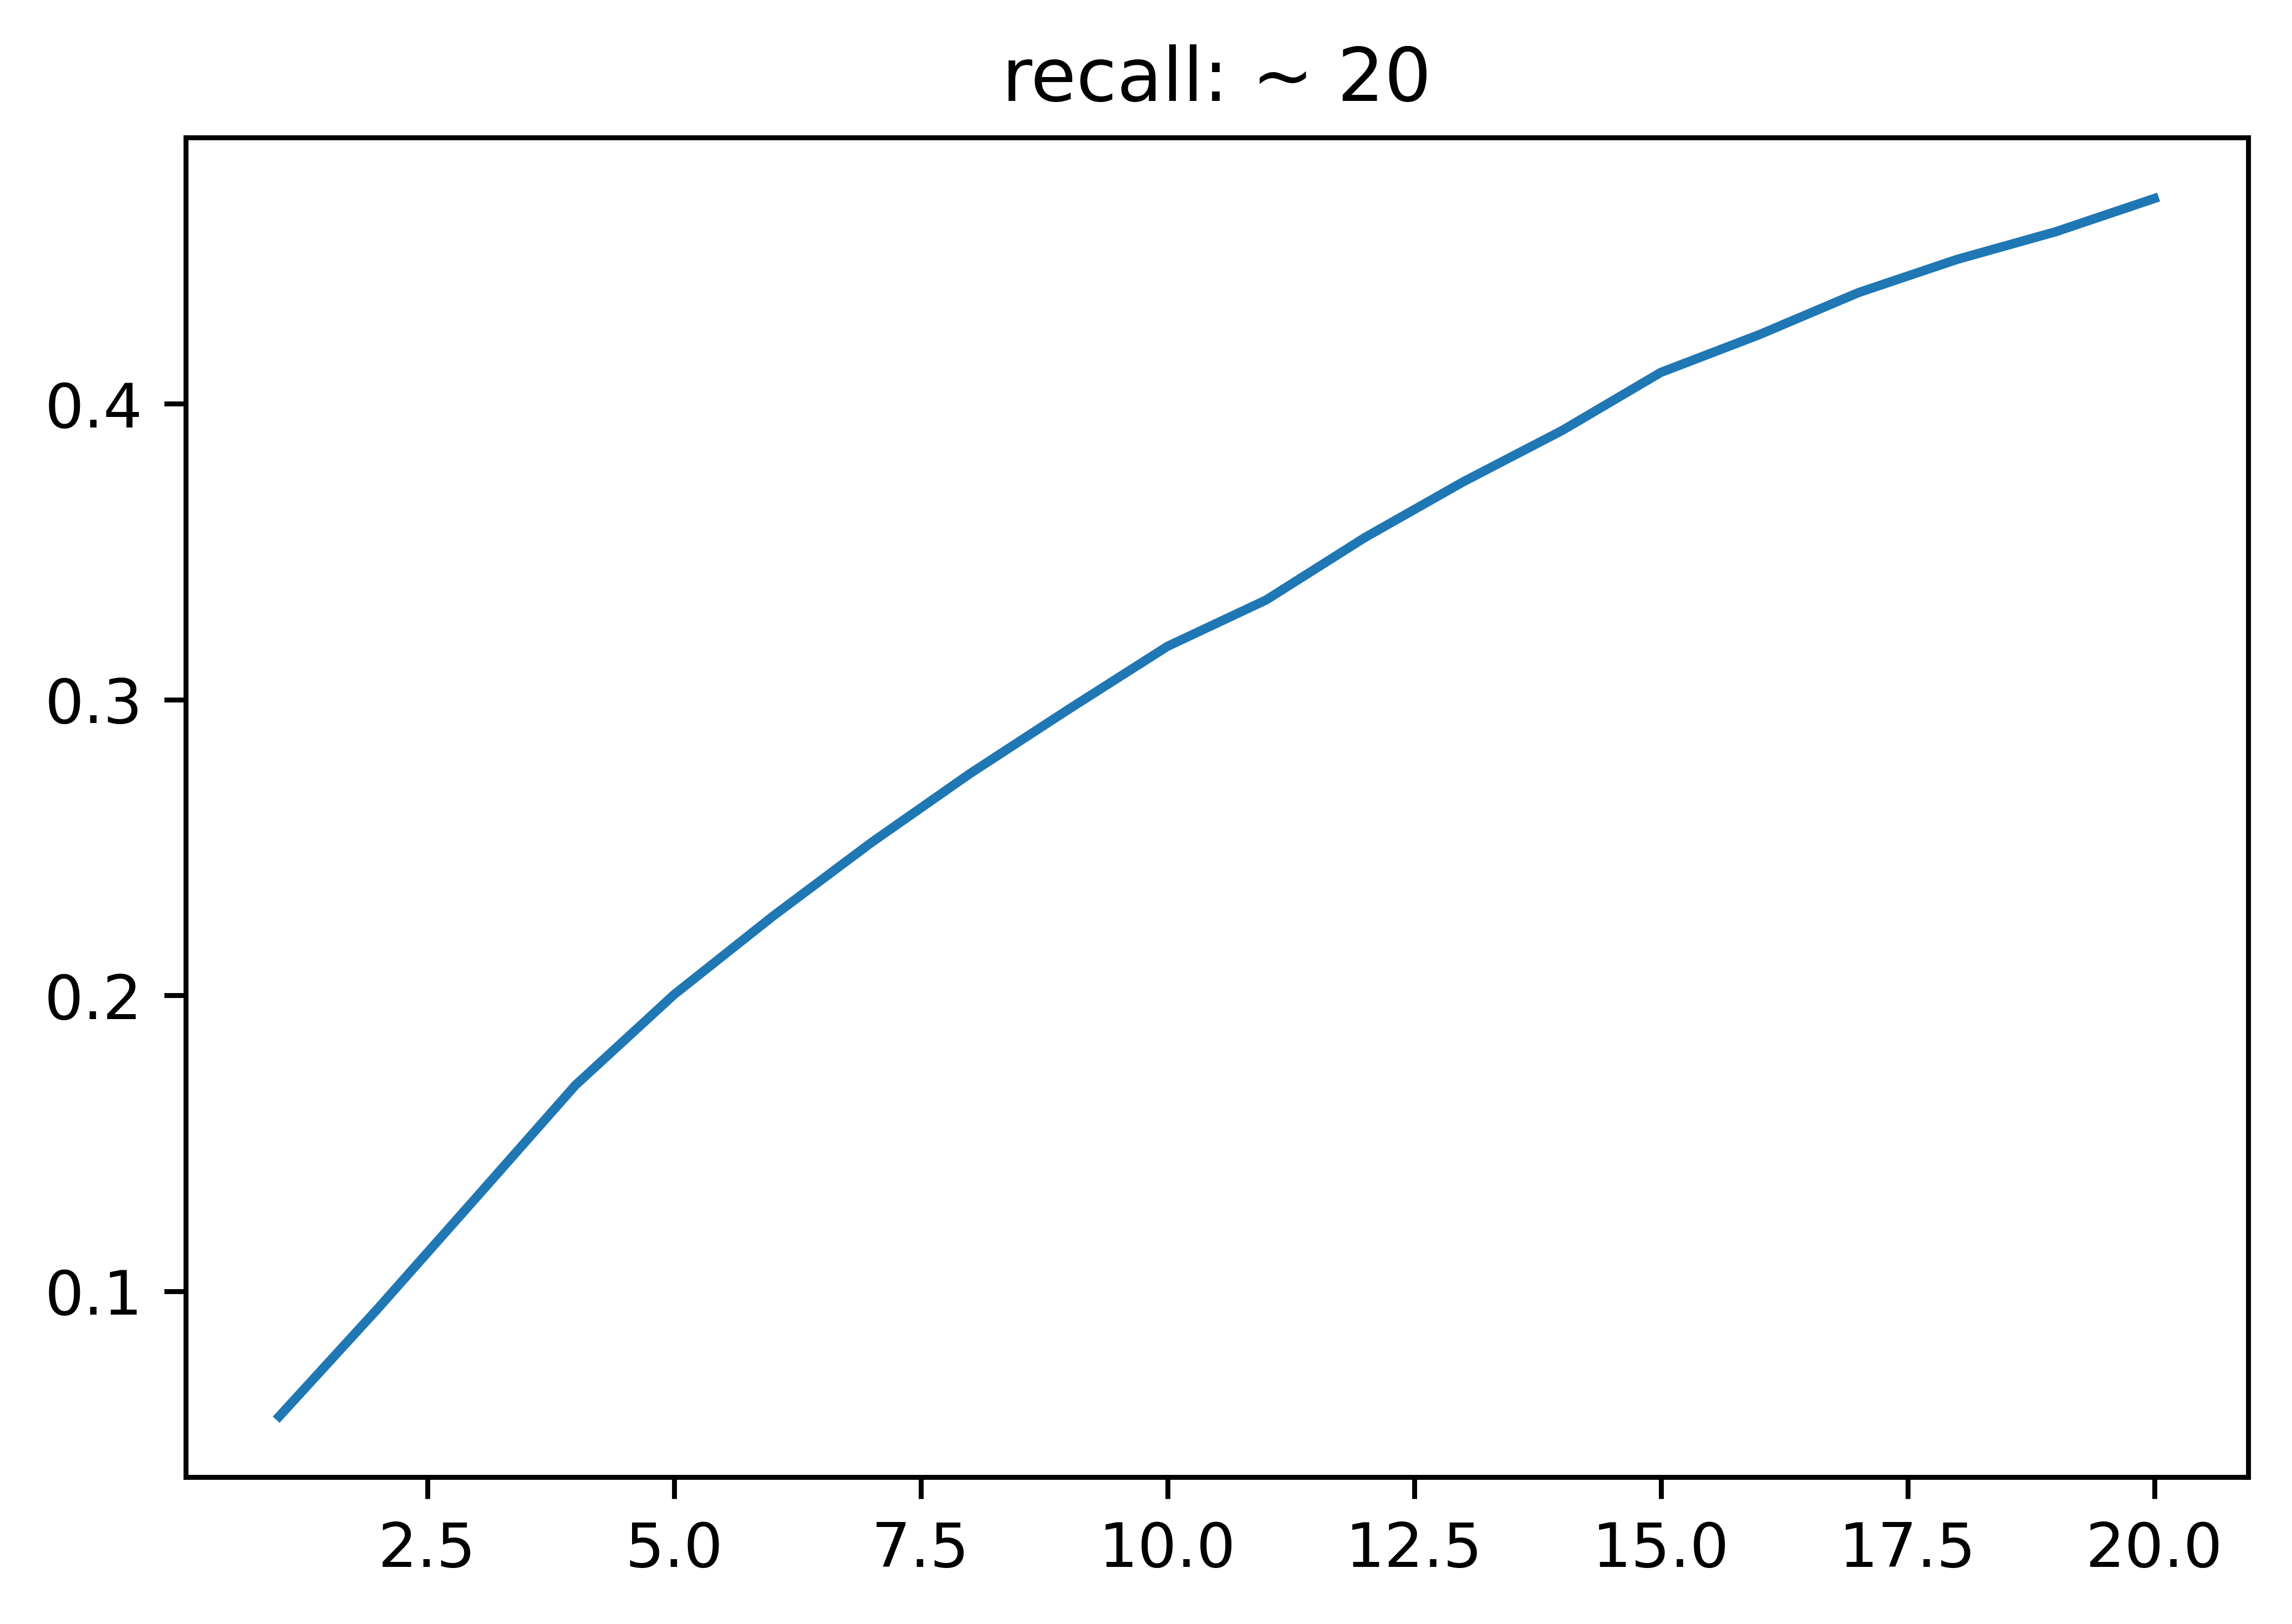

In [67]:
plt.figure(dpi = 800)
plt.plot(
    list(e for e in range(1,topk+1)), 
    metrics['recall'][:topk]
)
plt.title(f"recall: ~ {topk}")
plt.savefig(os.path.join(commoncourse_savepath, "metrics", "recall.jpg"))
plt.show()

## METHOD 2

CBMF

- reference: 
  - __Improving Top-N Recommendation for Cold-Start Users via Cross-Domain Information__
  - Authors: 
    Nima Mirbakhsh, Charles X. Ling
    
  - ACM Transactions on Knowledge Discovery from DataVolume 9Issue 4June 2015

In [16]:
%load_ext autoreload
%autoreload
from RS.MatrixFactorization import WeightedALS_MF as WALSMF
from RS.utils.plotutils import plotLoss
d = torch.device('cuda:3')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
cbmf_savepath = os.path.join("result", "CBMF")
if not os.path.exists(cbmf_savepath):
    print(f"mkdir : {cbmf_savepath}")
    os.mkdir(cbmf_savepath)
    os.mkdir(os.path.join(cbmf_savepath, "metrics"))

#### Build Cross Domain user item matrix

In [ ]:
from RS.utils.dataset import Crossdomain

In [ ]:
datafolder = {
    "training_user_course":os.path.join(
        dataroot,"course","train.csv"
    ),
    "training_user_book":os.path.join(
        dataroot,"book","user_cate3_train.csv"
    ),
    "testing_user_course":os.path.join(
        dataroot, "course", "test.csv"
    ),
    "testing_user_book":os.path.join(
        dataroot, "book", "user_cate3_test.csv"
    )
}

dataset = Mydataset(datafolder=datafolder)
dataset.getdata("testing_user_book").head()

$$\begin{bmatrix}
&|&\text{book}_1&\text{book}_2&...&|&\text{course}_1&\text{course}_2&...\\
--&--&--&--&--&--&--&--&--&\\
u_{\text{train}_1}&|&&&&|\\
u_{\text{train}_2}&|&&&&|\\
...&|&&&&|\\
--&--&--&--&--&--&--&--&--&\\
u_{\text{test}_1}&|&&&&|\\
u_{\text{test}_1}&|&&&&|\\
...&|&&&&|\\
\end{bmatrix}$$

In [40]:
dataset.mask_dataset("testing_user_book").head()

,uid,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,499110001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,499110003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,499110005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,499110006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,499110008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
info = {
    'testing_range':dataset.getdata(
        dataname="training_user_book"
    ).shape[0],
    'testing_user': dataset.getdata(
        dataname="testing_user_book"
    ).uid.tolist(),
    'all_book':dataset.getdata(
        dataname="testing_user_book").drop(columns=['uid']
        ).columns.tolist(),
    'all_course':dataset.getdata(
        dataname="testing_user_course").drop(columns=['uid'] 
        ).columns.tolist()
}
writejson(
    info, 
    os.path.join(dataroot, "crossdomain", "crossdomain_info.json")
)

In [ ]:
book_nor_crossdomain = Crossdomain(dataset_=dataset)
book_nor_crossdomain.head()

In [41]:
book_nor_crossdomain.to_csv(
    os.path.join(dataroot, "crossdomain", "book_nor_crossdomain.csv"),
    index=False
)

In [42]:
book_nor_crossdomain_tensor = torch.tensor(
    book_nor_crossdomain.drop(columns=['uid']).values,
    dtype=torch.double
)
torch.save(book_nor_crossdomain_tensor, os.path.join(
    "data", "crossdomain", "book_nor_crossdomain.pt")
)

torch.Size([21829, 8054])


### Non Clustering 

#### MF

In [112]:
book_nor_crossdomain_tensor= torch.load(
    os.path.join( "data", "crossdomain", "book_nor_crossdomain.pt")
)

random loss: 102.00598949001095


100%|██████████| 5/5 [11:05<00:00, 133.08s/it, currentbest=0.004, mse=0.005, improve=-0.0003, early=0] 


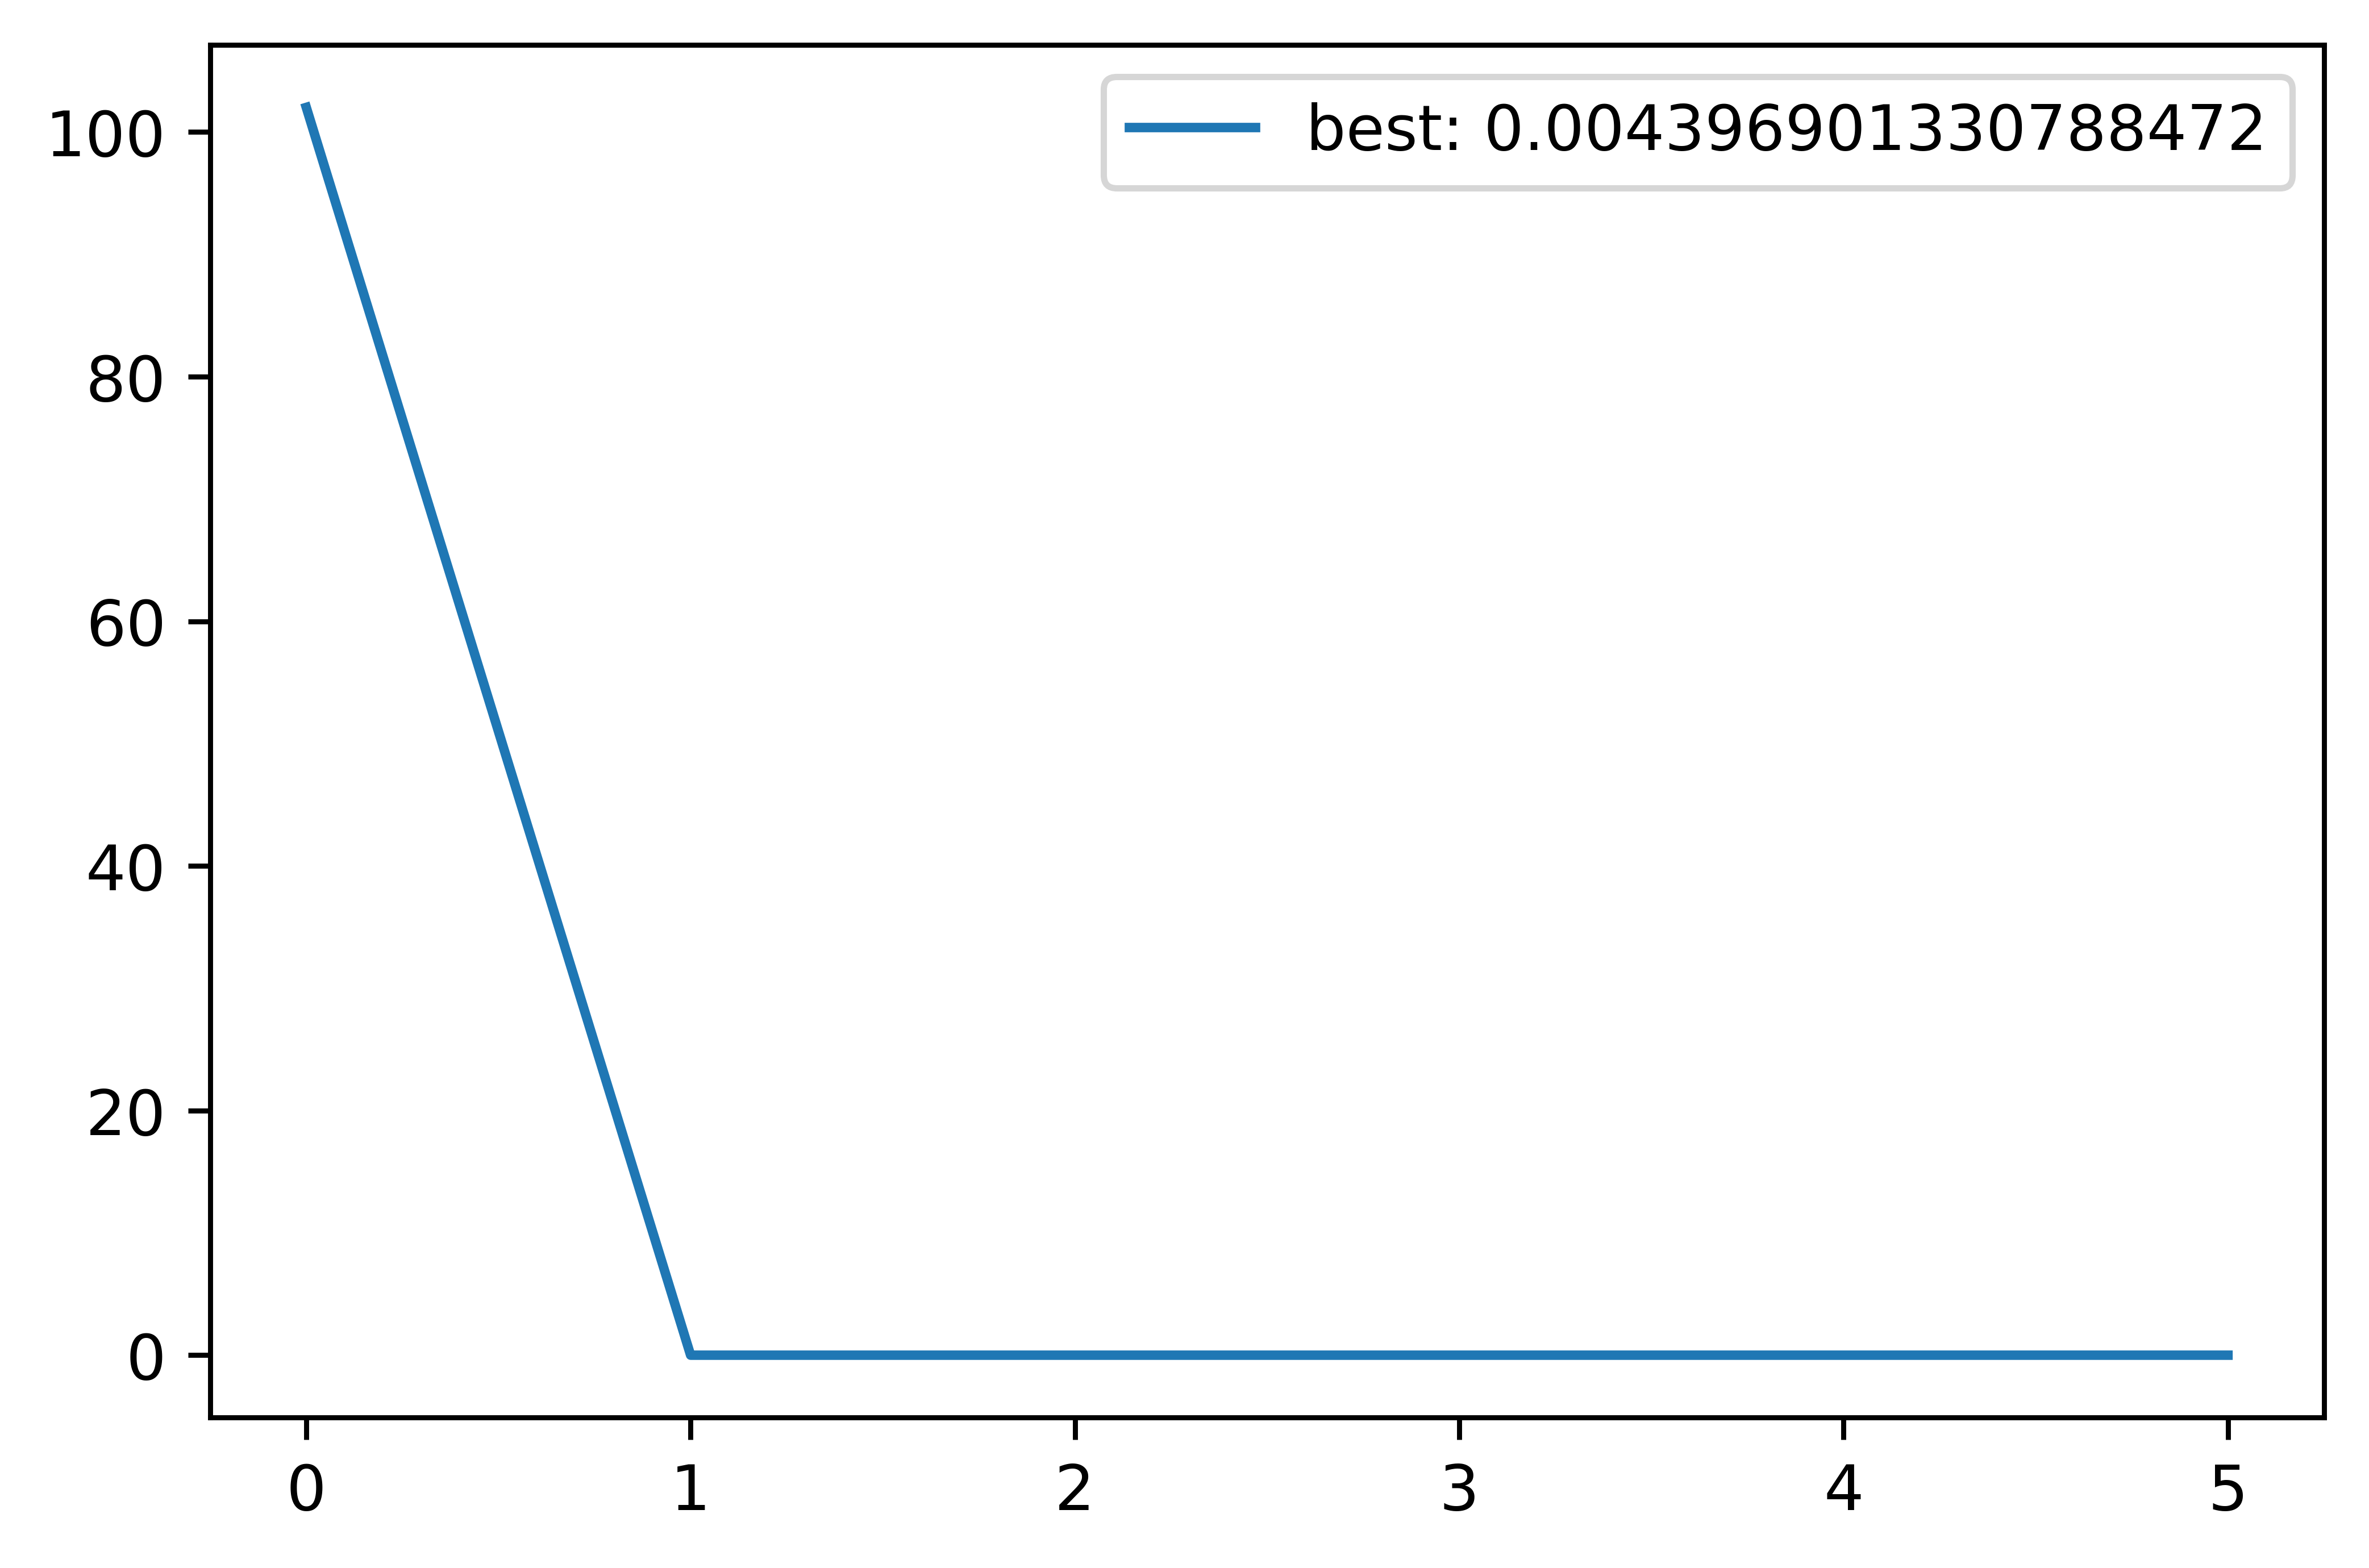

In [115]:
mf = WALSMF(
    R=book_nor_crossdomain_tensor, 
    fill_empty=torch.mean(book_nor_crossdomain_tensor)/2, 
    w_m=0.001
)
h = mf.train(
    device=d,tmp_savepath=os.path.join(
        cbmf_savepath, "nonclustering", "with_w_latency"
    )
)
plotLoss(
    h['loss'], 
    savename=os.path.join(
        cbmf_savepath, "nonclustering", "wmse.jpg"
    ), showinline=True
)

In [116]:
user_l = torch.load(
    os.path.join(
        cbmf_savepath, "nonclustering", "with_w_latency","user.pt"
    )
)
print(user_l.size())
item_l = torch.load(
    os.path.join(
        cbmf_savepath, "nonclustering", "with_w_latency","item.pt"
    )
)
print(item_l.size())
predction = ((user_l.to(device=d))@(item_l.T.to(device=d))).cpu()
print(predction.size())

torch.save(
    predction,
    os.path.join(cbmf_savepath, "nonclustering","wprediction.pt")
)

torch.Size([21829, 40])
torch.Size([8054, 40])
torch.Size([21829, 8054])


In [117]:
info = loadjson(os.path.join("data","crossdomain","crossdomain_info.json"))


In [118]:
testing_range = info['testing_range']
testing_user=info['testing_user']
print(testing_range)

20575


In [119]:
testing_user_book_prediction = predction[testing_range:, 0:1000].numpy()
print(testing_user_book_prediction.shape)

(1254, 1000)


In [120]:
rlist = {}
for i, testu in tqdm(
    enumerate(testing_user), total=len(testing_user)
):
    rank = np.argsort(-testing_user_book_prediction[i]).tolist()
    rlist[testu] = list(str(cate) for cate in rank)



100%|██████████| 1254/1254 [00:00<00:00, 3180.21it/s]


In [121]:
writejson(
    rlist, 
    os.path.join(cbmf_savepath, "nonclustering", "recommendlist.json")
)

#### Evaluation

In [7]:
Evaluate(
    result_root = os.path.join(cbmf_savepath, "nonclustering"), 
    recommendlist = os.path.join(cbmf_savepath, "nonclustering", "recommendlist.json"),
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=list(str(i) for i in range(1000))
)

result/CBMF/nonclustering/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:46<00:00,  1.19s/it]


Precision_Recall_F1 : result/CBMF/nonclustering/metrics/metrics.jpg
PR : result/CBMF/nonclustering/metrics/PR.jpg
ROC : result/CBMF/nonclustering/metrics/ROC.jpg


### Clustering regularization

In [15]:
cbmatrix = np.load(os.path.join(
    cbmf_savepath, "clustering", "cb.npy")
)
cbmatrix.shape

(201, 110)

#### CBMF

random loss: 23.54499729704937


100%|██████████| 5/5 [00:04<00:00,  1.24it/s, currentbest=0.315, mse=0.315, improve=-0.0000, early=0]


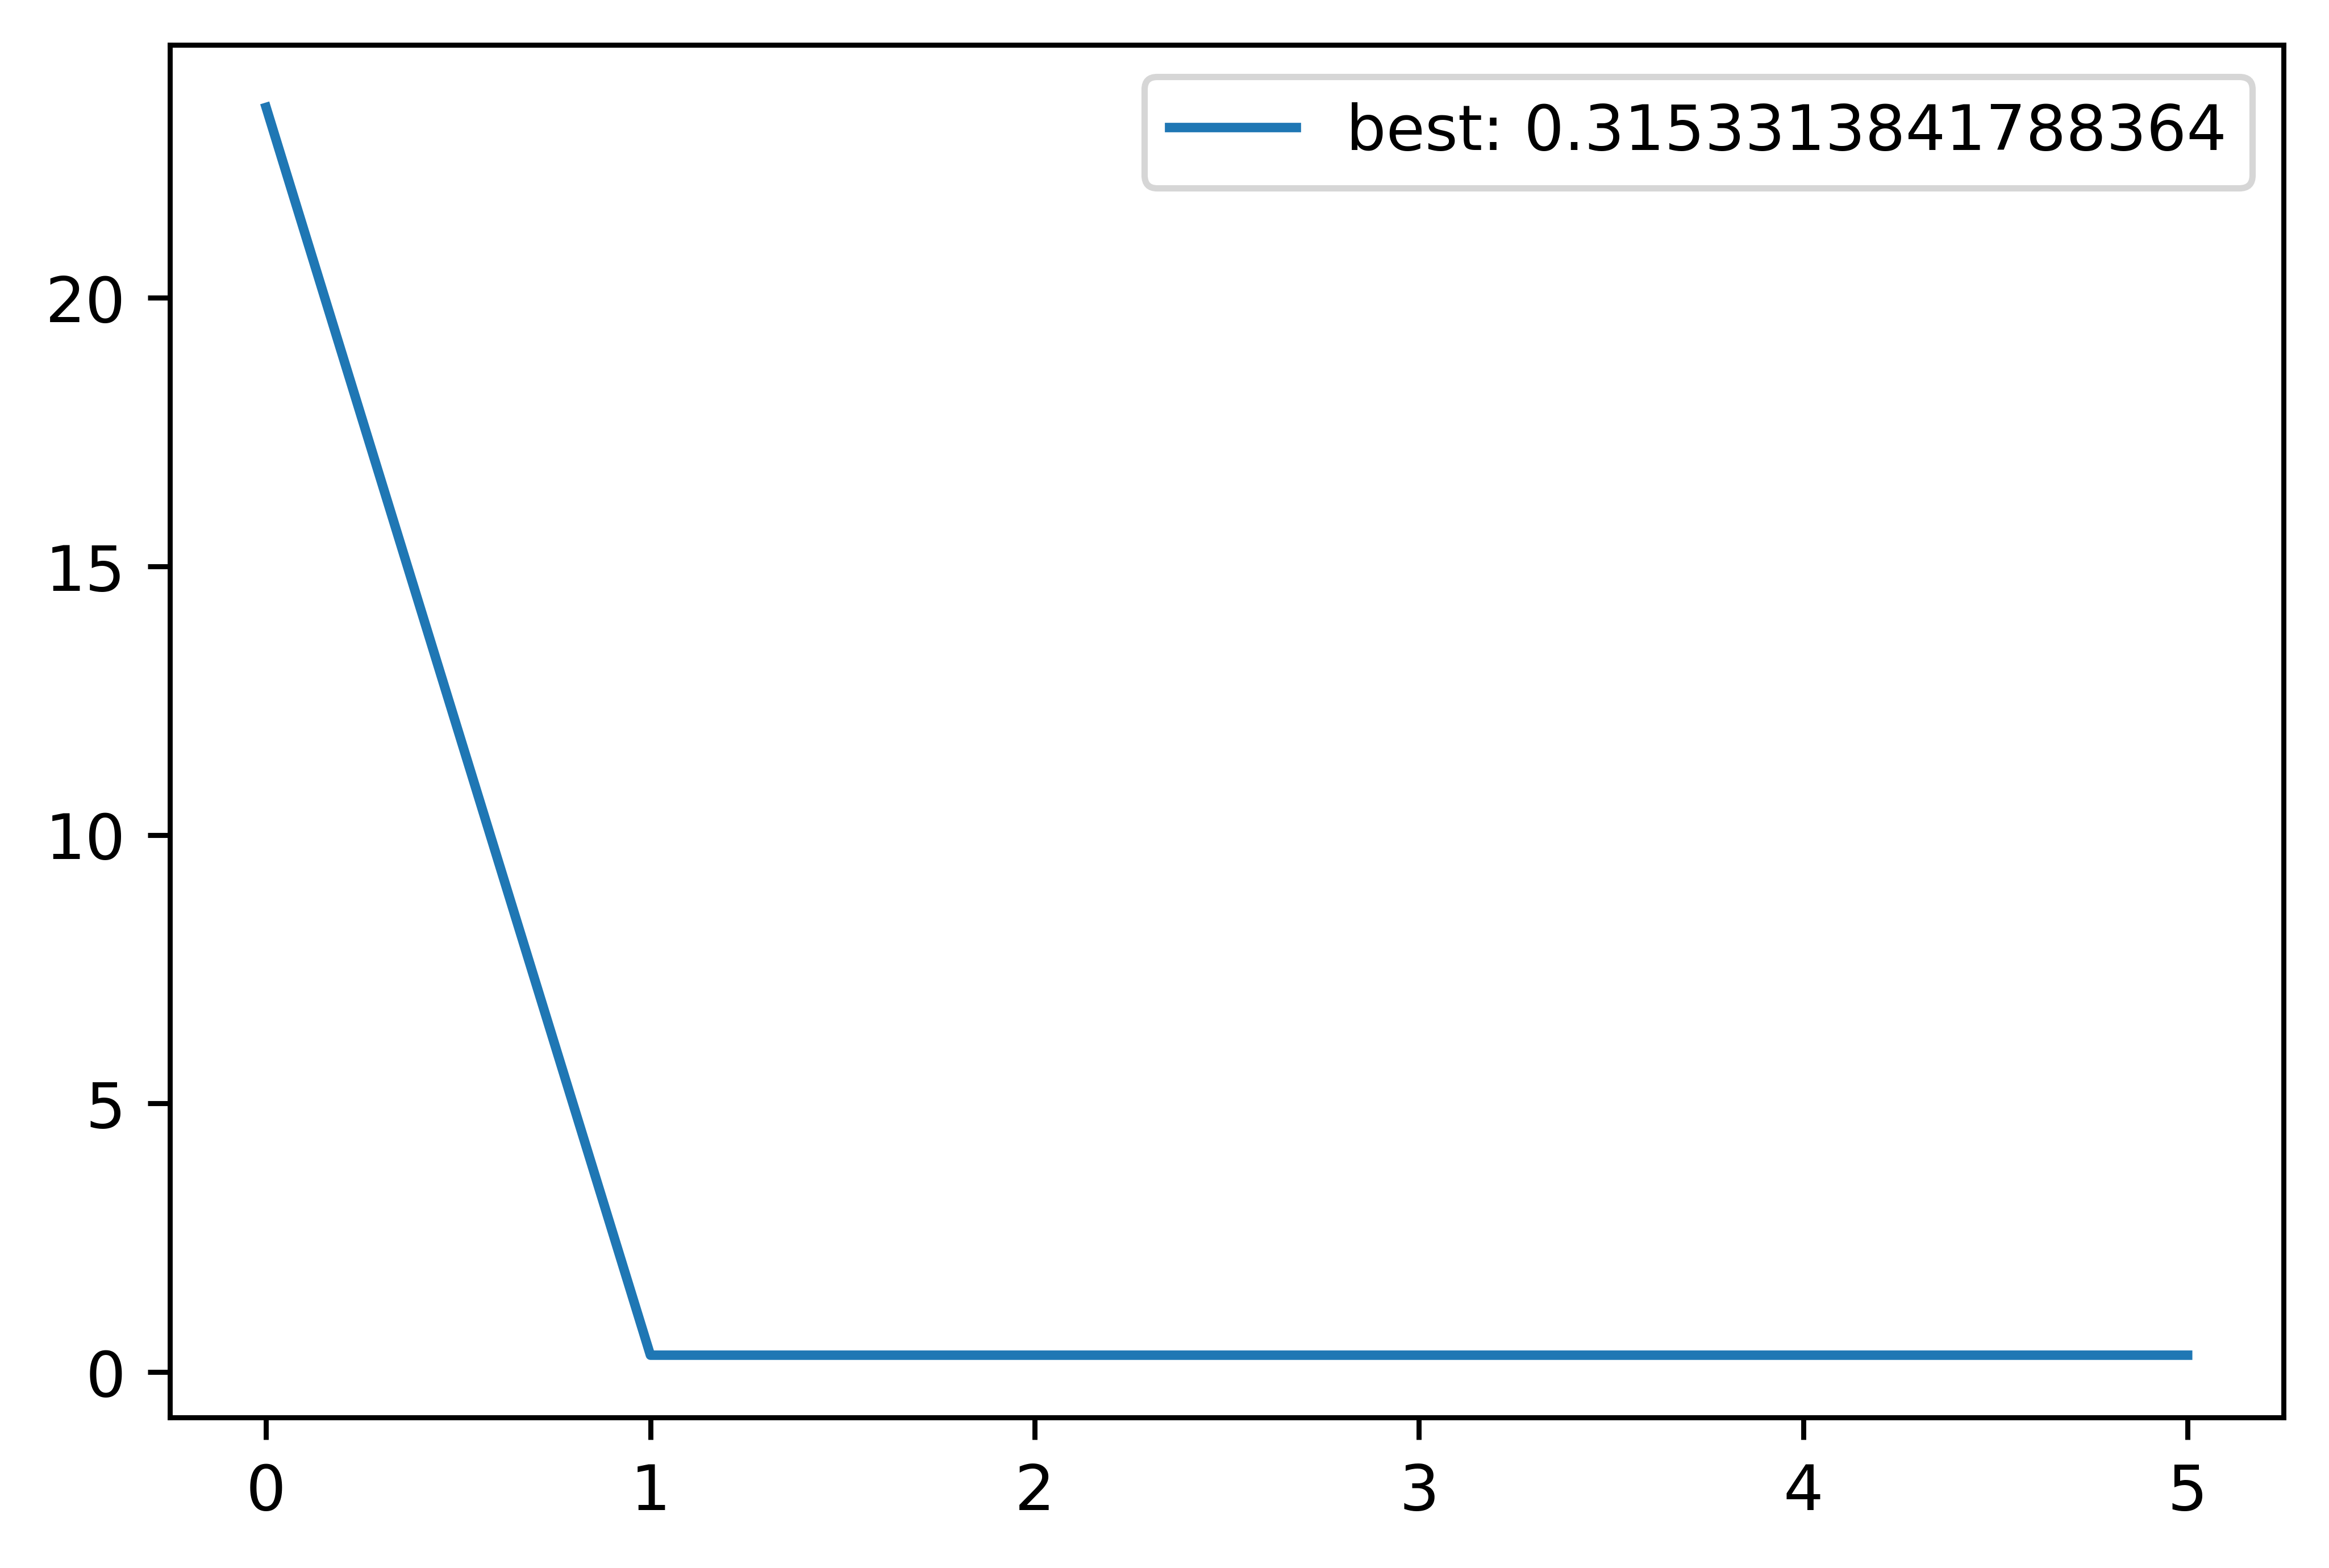

In [19]:
cbmf = WALSMF(
    R=torch.tensor(cbmatrix,dtype=torch.double), latency=20,
    l2_reg=0.9, fill_empty=np.mean(cbmatrix)/2, w_m=0.9
)
h = cbmf.train(
    device=d,tmp_savepath=os.path.join(
        cbmf_savepath, "clustering", "with_w_latency"
    )
)
plotLoss(
    h['loss'], 
    savename=os.path.join(
        cbmf_savepath, "clustering", "wmse.jpg"
    ), showinline=True
)

In [21]:
user_c_l = torch.load(
    os.path.join(
        cbmf_savepath, "clustering", "with_w_latency","user.pt"
    )
)
print(user_c_l.size())
item_c_l = torch.load(
    os.path.join(
        cbmf_savepath, "clustering", "with_w_latency","item.pt"
    )
)
print(item_c_l.size())


torch.Size([201, 20])
torch.Size([110, 20])
torch.Size([201, 110])


#### final prediction

In [22]:
info = loadjson(os.path.join("data","crossdomain","crossdomain_info.json"))
testing_range = info['testing_range']
testing_user=info['testing_user']
print(testing_range)

20575


In [25]:
nonclustering = torch.load(
    os.path.join(cbmf_savepath, 
    "nonclustering","wprediction.pt")
).numpy()[testing_range:, 0:1000]
print(nonclustering.shape)


(1254, 1000)
(201, 110)


In [27]:
user_c_l = user_c_l.numpy()
item_c_l = item_c_l.numpy()

In [26]:
user_clustering = {
    'book':loadjson(
        os.path.join(
            cbmf_savepath,"clustering","bookdataset",
            "userclustering","cluster.json")
        ),
    'course':loadjson(
        os.path.join(
            cbmf_savepath,"clustering","coursedataset",
            "userclustering","cluster.json")
    )
}


In [30]:
alpha = 0.3

In [33]:
rlist = {}
for i, testu in tqdm(enumerate(testing_user), total=len(testing_user)):
    
    cates = nonclustering[i]
    itcoursecluster = np.Inf
    for k,v in user_clustering['course'].items():
        if int(testu) in v:
            itcoursecluster = int(k)
            break
    cluster_suggest = \
        (user_c_l[itcoursecluster,:])@(item_c_l[-10:, :].T)

    cates = (1-alpha)*cates + \
        alpha*np.repeat(cluster_suggest, 100)
        
    rank = np.argsort(-cates).tolist()
    rlist[testu] = list(str(cate) for cate in rank)



100%|██████████| 1254/1254 [00:00<00:00, 1688.05it/s]


In [34]:
writejson(
    rlist, 
    os.path.join(cbmf_savepath, "clustering", "recommendlist.json")
)

In [35]:
Evaluate(
    result_root = os.path.join(cbmf_savepath, "clustering"), 
    recommendlist = os.path.join(cbmf_savepath, "clustering", "recommendlist.json"),
    gth = os.path.join("result", "testing_user_groundtruth.json"),
    item_list=list(str(i) for i in range(1000))
)

result/CBMF/clustering/metrics/metrics.json
calculate precision, recall, f1, falsepositive rate


100%|██████████| 1000/1000 [19:51<00:00,  1.19s/it]


Precision_Recall_F1 : result/CBMF/clustering/metrics/metrics.jpg
PR : result/CBMF/clustering/metrics/PR.jpg
ROC : result/CBMF/clustering/metrics/ROC.jpg


## Comparison Recall for top 30

In [36]:
from RS.utils.plotutils import plot_comparison

In [37]:
recall_list = {
    "method":[],
    "recall":[]
}
metric_path = os.path.join("metrics", "metrics.json")

In [38]:
commoncourse_metric = loadjson(
    os.path.join("result", "commoncourse",metric_path)
)
CrossMF_metric = loadjson(
    os.path.join("result", "CBMF" ,"clustering",metric_path)
)

In [45]:
recall_list['method'] = ['commoncourse', 'CrossMF']
recall_list['recall'] = [
    commoncourse_metric['recall'][1:31], 
    CrossMF_metric['recall'][1:31]
]

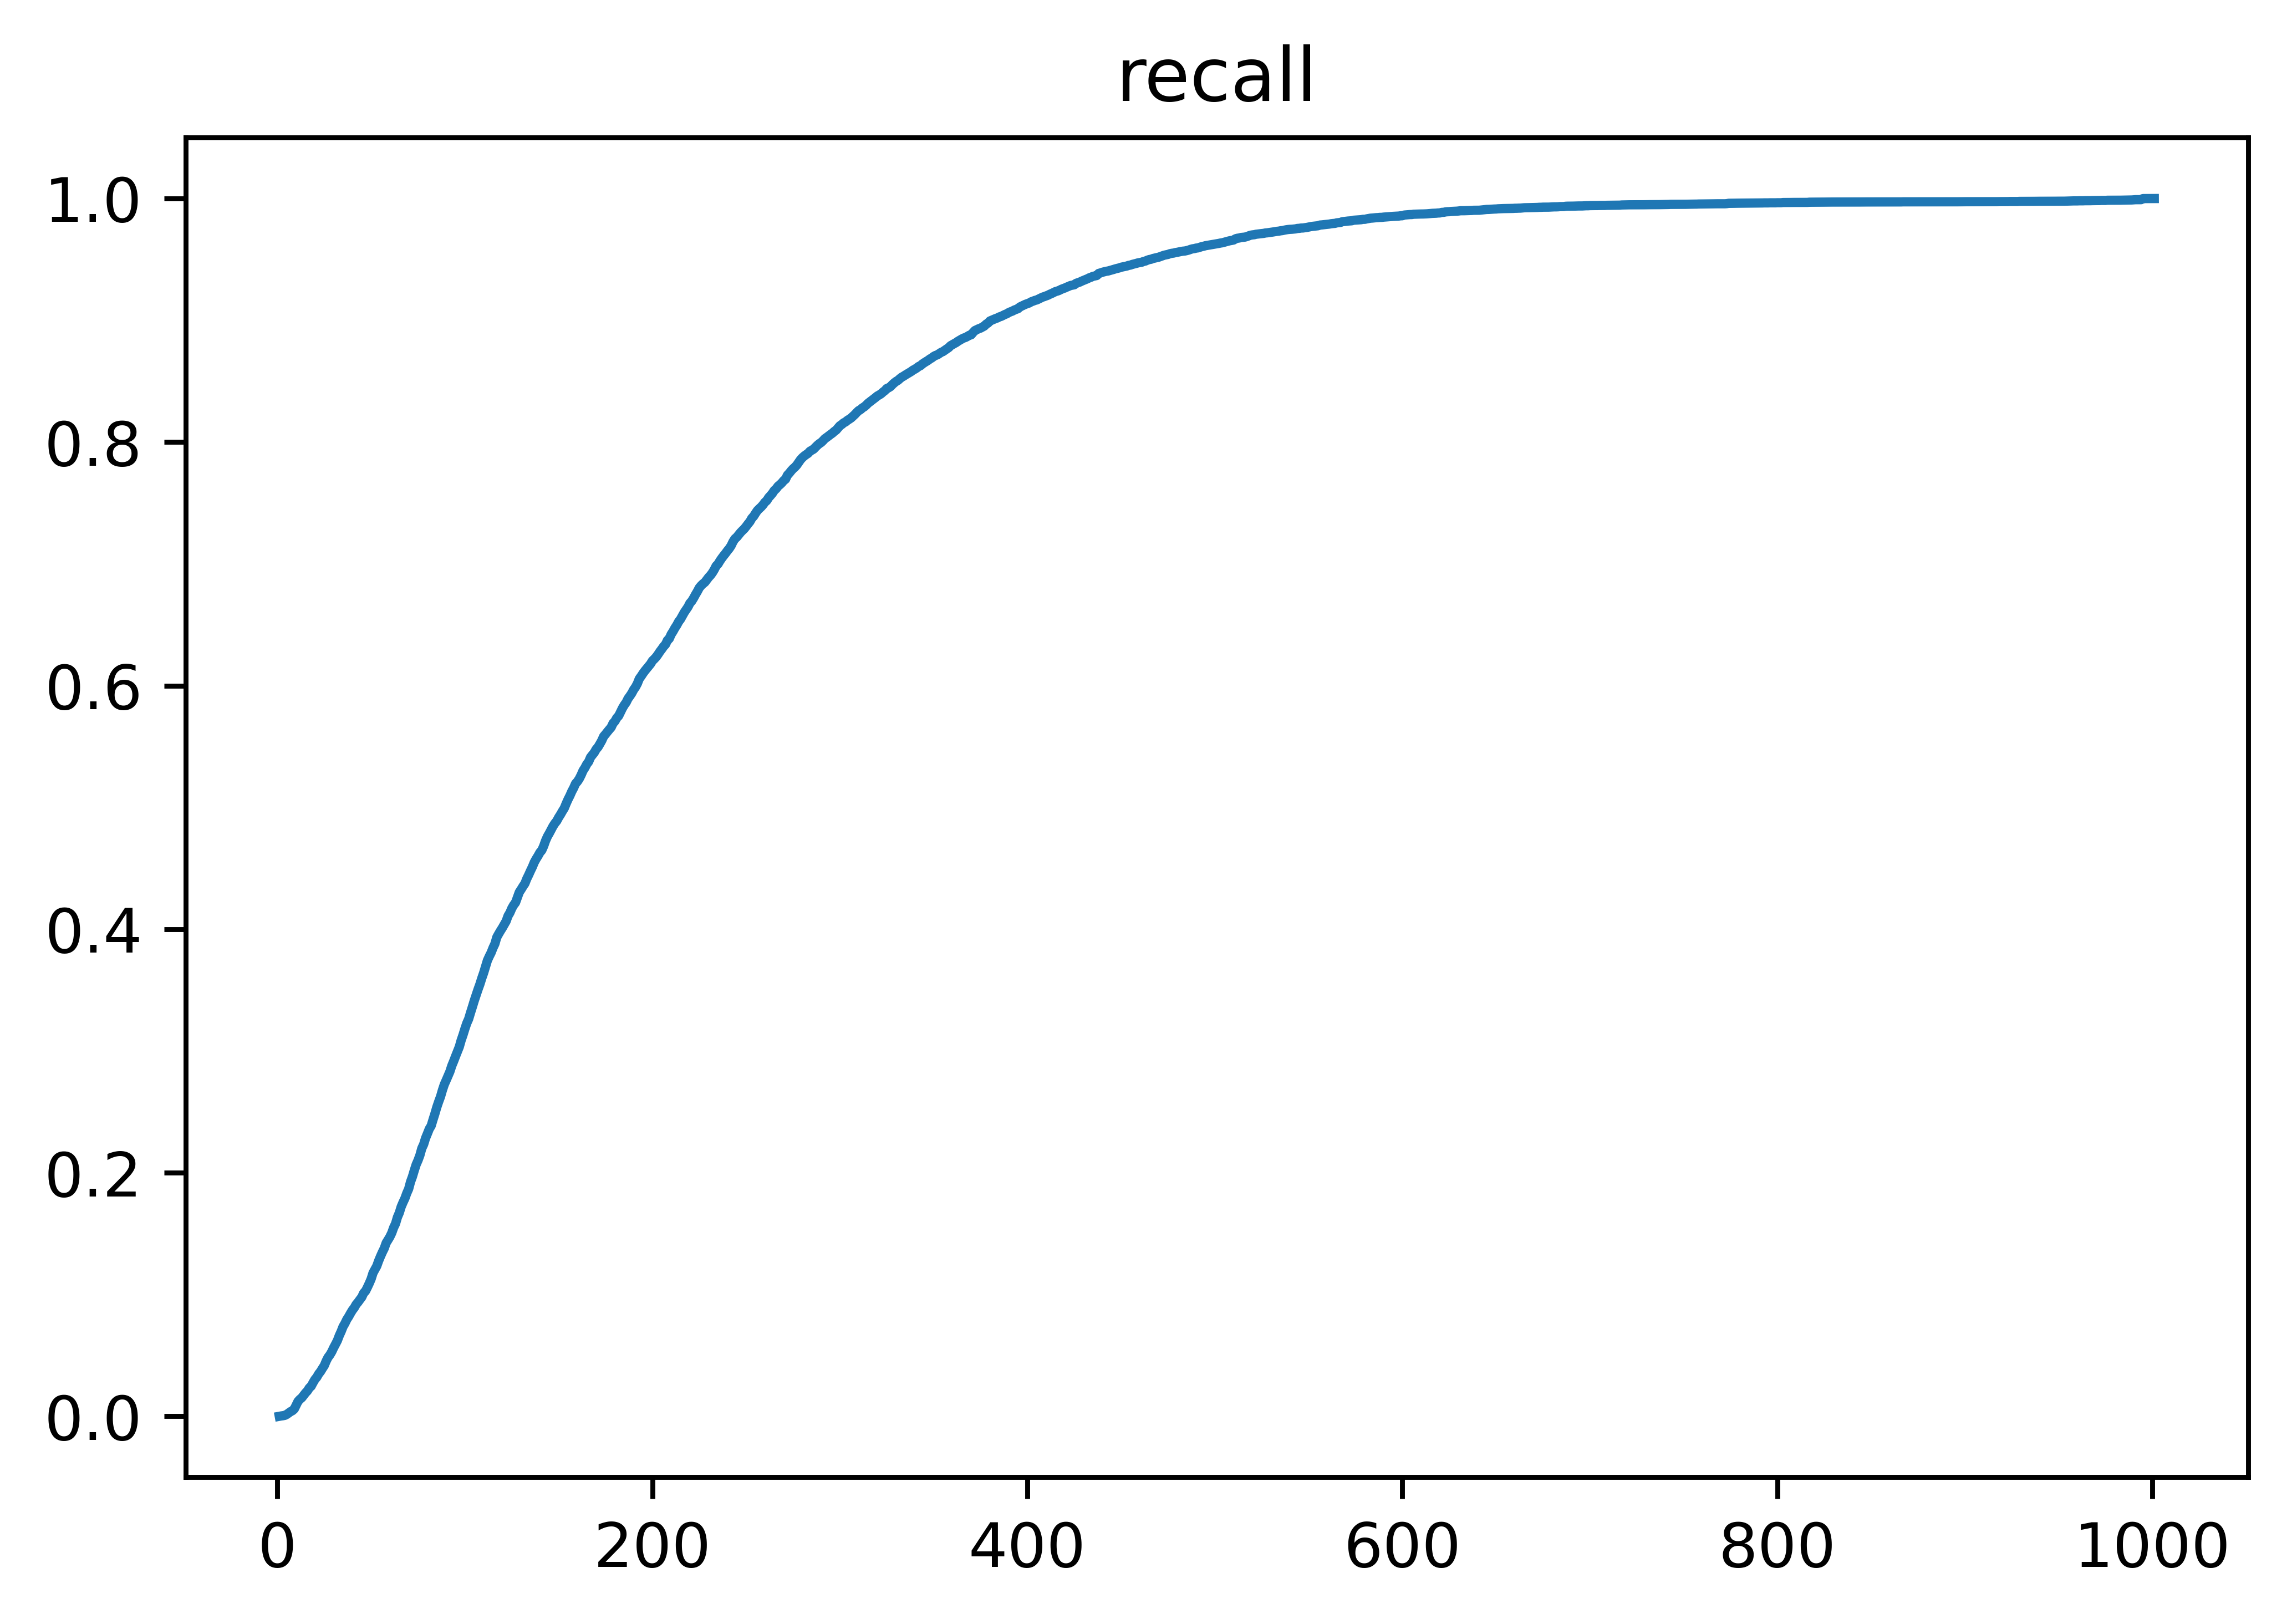

In [68]:
plt.figure(dpi=800)
plt.plot(
    list(e for e in range(1, len(CrossMF_metric['recall'])+1)),
    CrossMF_metric['recall']
)
plt.title("recall")
plt.savefig(os.path.join(cbmf_savepath, "clustering","metrics","recall.jpg"))
plt.show()

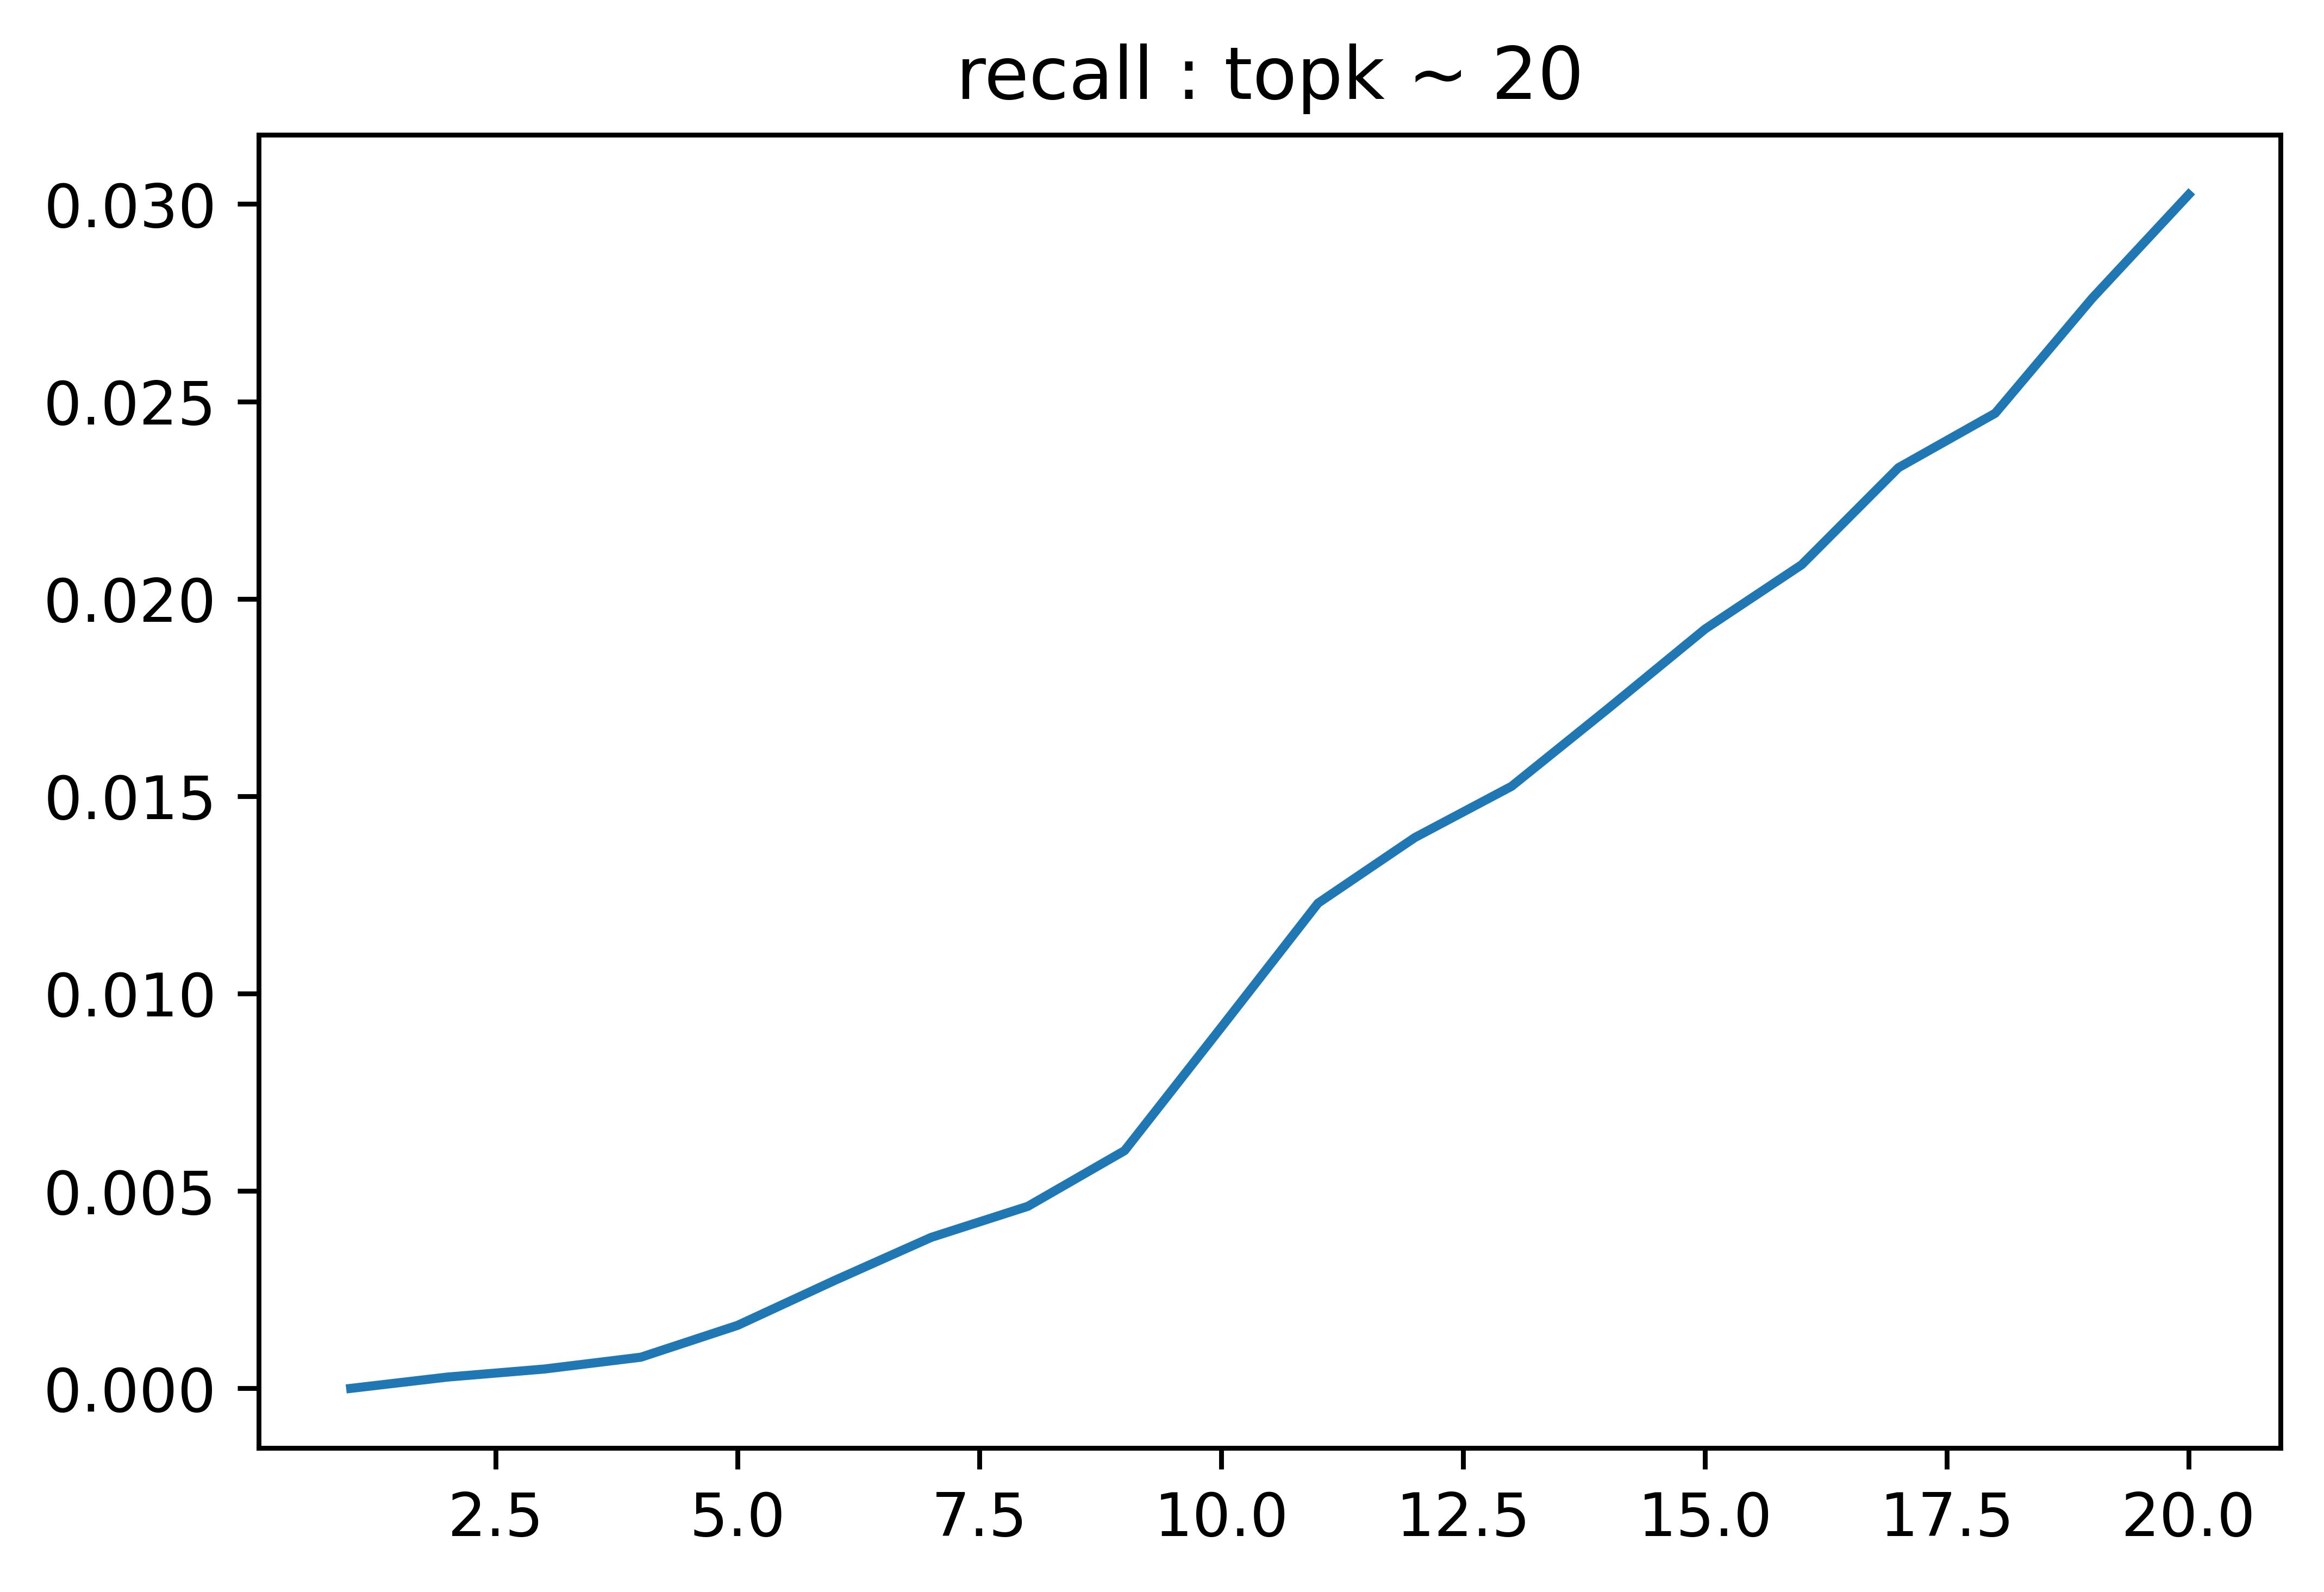

In [69]:
topk = 20
plt.figure(dpi=800)
plt.plot(
    list(e for e in range(1, 
        len(CrossMF_metric['recall'][:topk])+1)
    ),
    CrossMF_metric['recall'][:topk]
)
plt.title(f"recall : topk ~ {topk}")
plt.savefig(os.path.join(cbmf_savepath, "clustering","metrics","zoomin_recall.jpg"))
plt.show()

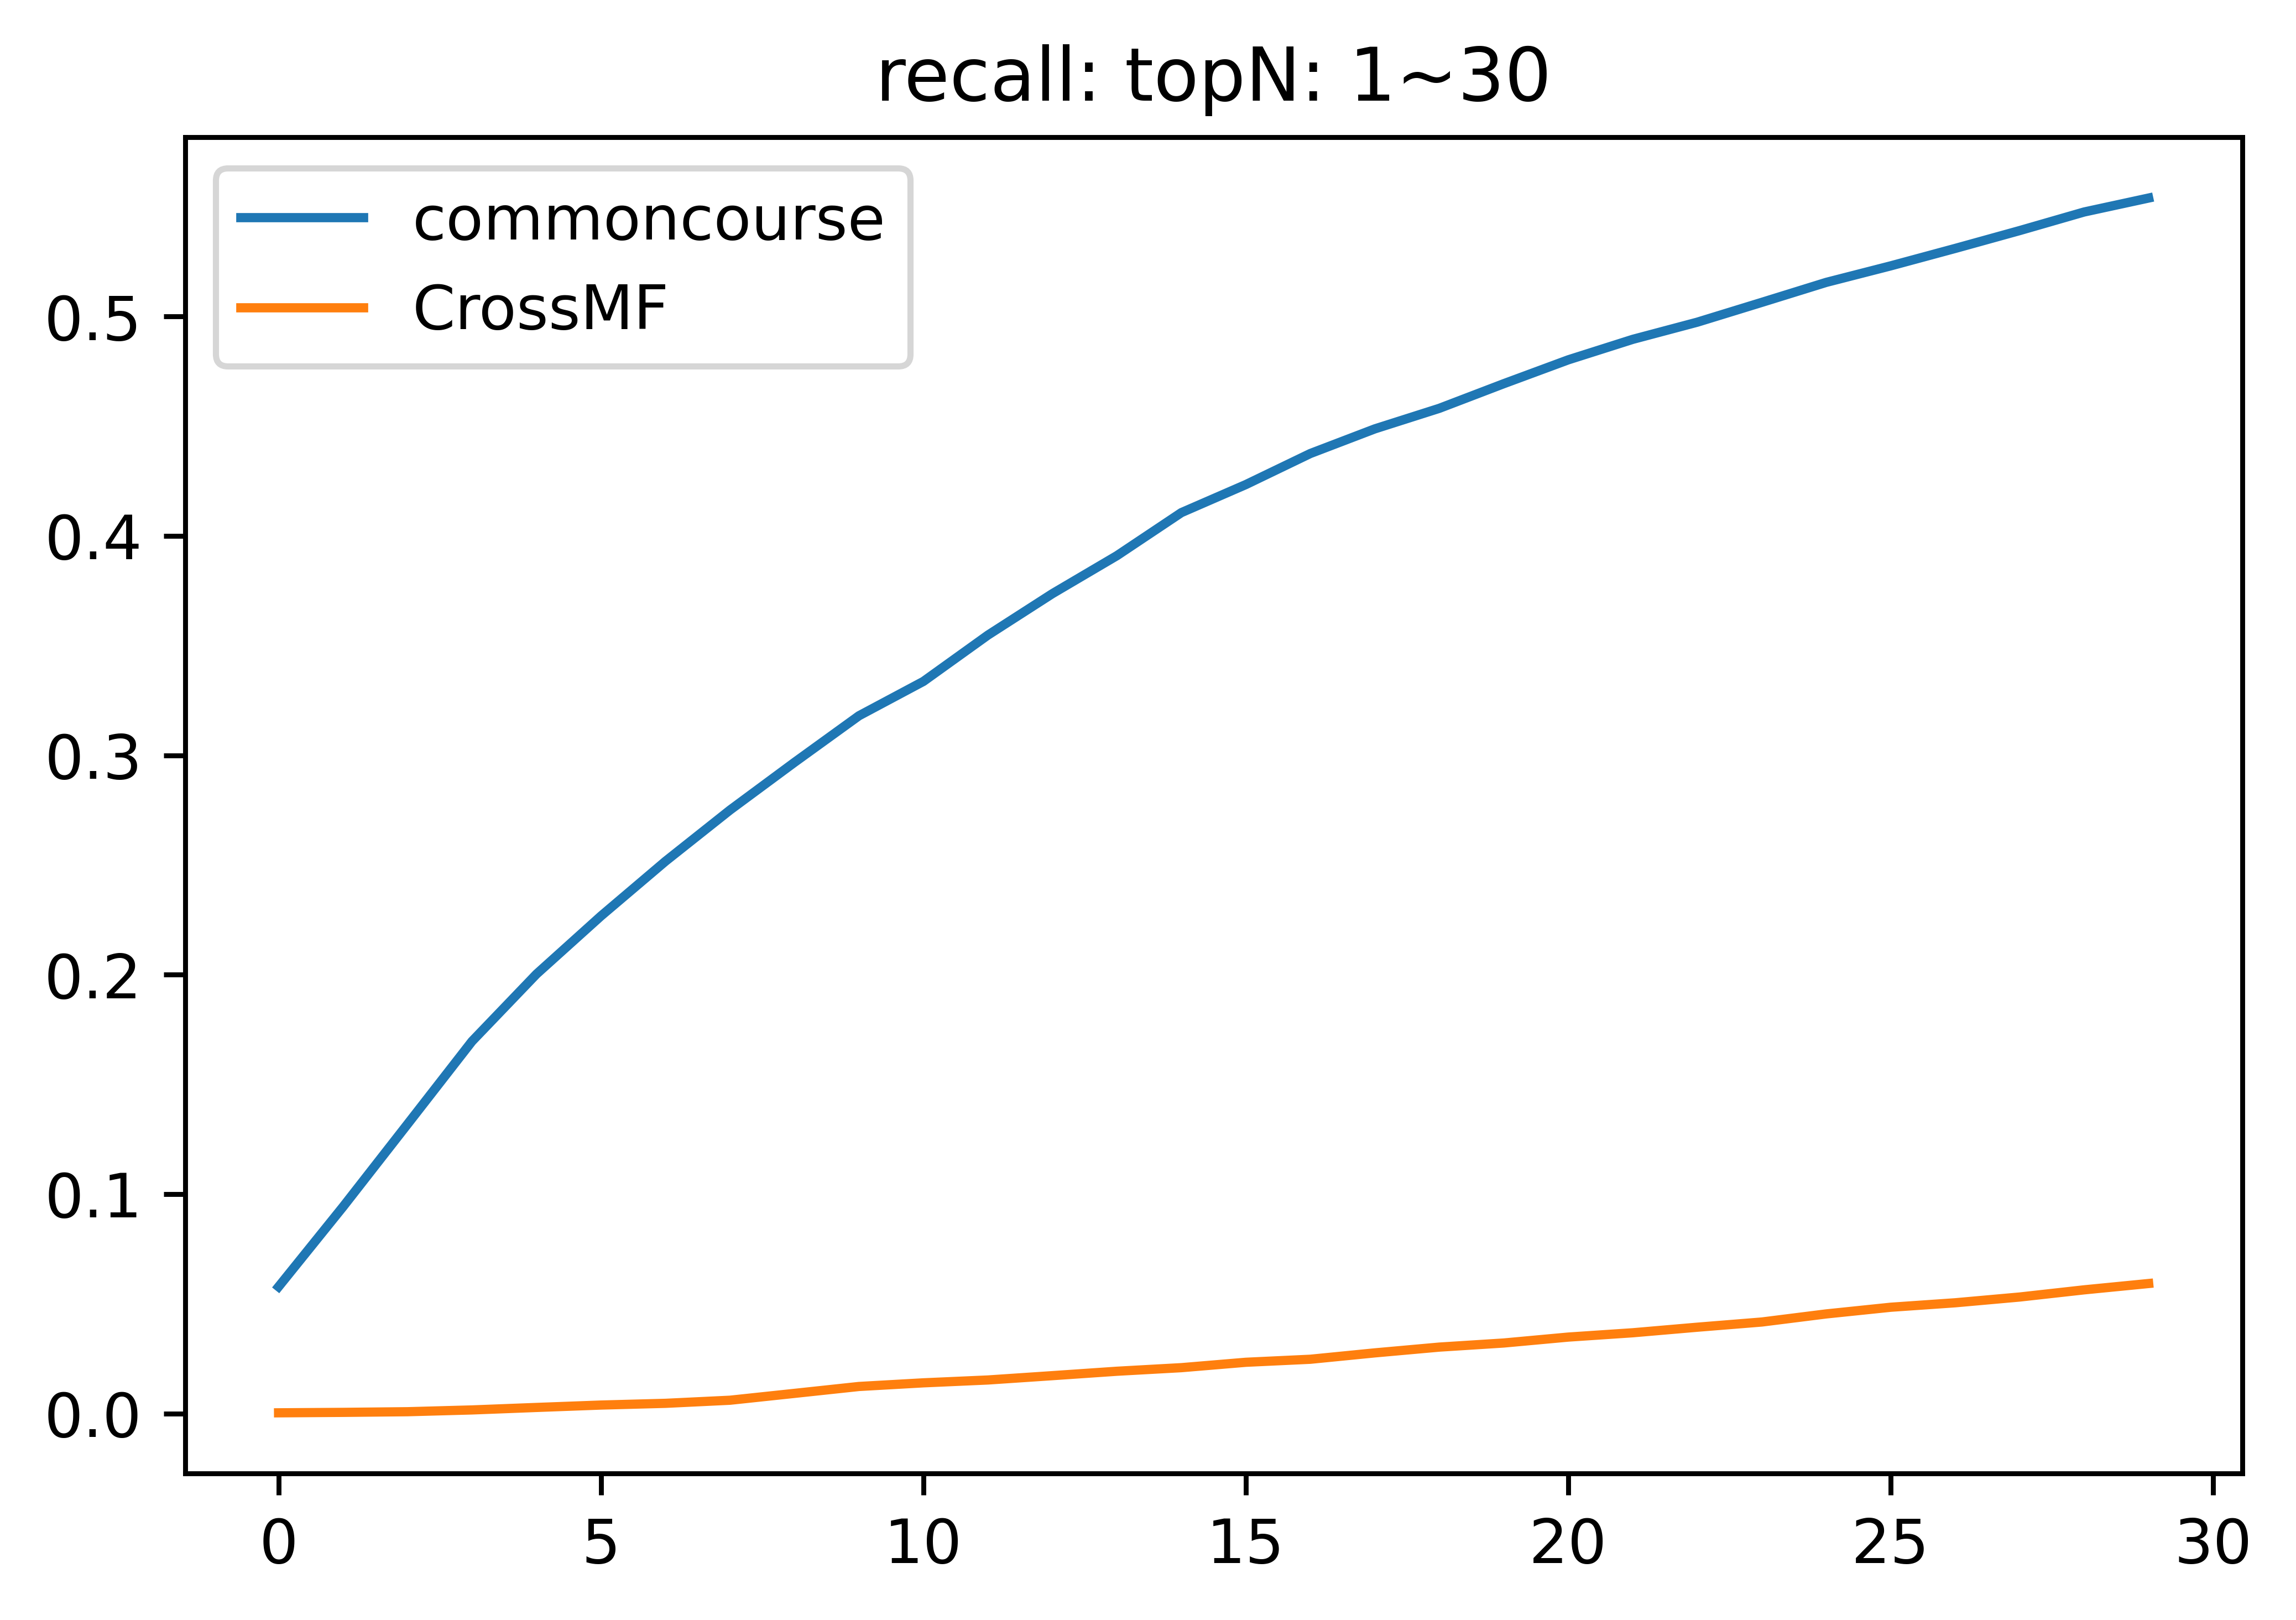

In [46]:
plot_comparison(
    x = recall_list['recall'],
    labels=recall_list['method'],
    savename=os.path.join("result", "Comparsion_recall.jpg"),
    title="recall: topN: 1~30",
    showinline=True
)